### Importações e Configurações

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import json
from pathlib import Path
import yaml

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [4]:
# Caminho para Salvar os Arquivos

path_img = './outputs/plots/'
path_metrics = './outputs/metrics/'
path_param = './outputs/param/'

### Carregamento dos Dados com Engenharia de Atributos

In [5]:
df = pd.read_csv('../3_feature_engineering/outputs/data/df_features.csv', parse_dates=['Date']).sort_values('Date')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,week,week_sin,week_cos,is_holiday,holiday_week,rolling_mean_4,lag_1,lag_52,Type_B,Type_C
0,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,18707.0275,18461.18,24924.50,False,False
165178,27,93,2011-02-04,59536.22,False,28.70,3.400,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,54553.6325,49569.16,64944.45,False,False
219664,38,10,2011-02-04,323.41,False,45.14,3.348,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,343.6300,374.50,351.77,False,True
78573,13,85,2011-02-04,4133.39,False,23.35,2.974,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,4150.6550,3925.15,5020.32,False,False
120781,20,67,2011-02-04,19376.29,False,28.58,3.231,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,12998.9900,11464.28,19251.67,False,False


### Processamento

In [6]:
# Seleção de Target e Features

target = "Weekly_Sales_log"

categorical_cols = ["Store_idx", "Dept_idx"]
binary_cols = ["IsHoliday_x"]

numerical_cols = [
    col for col in df.columns
    if col not in categorical_cols + binary_cols + ["Weekly_Sales", "Weekly_Sales_log", "Date"]
]

In [7]:
# Encoding Categórico

store_encoder = LabelEncoder()
dept_encoder = LabelEncoder()

df["Store_idx"] = store_encoder.fit_transform(df["Store"])
df["Dept_idx"] = dept_encoder.fit_transform(df["Dept"])

In [8]:
# Separação Atributos e Alvo

X_num = df[numerical_cols]
X_cat = df[categorical_cols].values.astype(np.int32)
X_bin = df[binary_cols].astype(int)

y = df[target].values.reshape(-1, 1)

In [9]:
# Normalização (somente numéricas)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_num_scaled = scaler_X.fit_transform(X_num)
y_scaled = scaler_y.fit_transform(y)

In [10]:
# Criação de janelas temporais (multi-input)

def create_sequences(num, cat, bin_, y, window):
    X_num_seq, X_cat_seq, X_bin_seq, y_seq = [], [], [], []

    for i in range(len(num) - window):
        X_num_seq.append(num[i:i+window])
        X_cat_seq.append(cat[i:i+window])
        X_bin_seq.append(bin_[i:i+window])
        y_seq.append(y[i+window])

    return (
        np.array(X_num_seq),
        np.array(X_cat_seq),
        np.array(X_bin_seq),
        np.array(y_seq)
    )

WINDOW_SIZE = 12

X_num_seq, X_cat_seq, X_bin_seq, y_seq = create_sequences(
    X_num_scaled,
    X_cat,
    X_bin.values,
    y_scaled,
    WINDOW_SIZE
)

In [11]:
# Split Temporal

split = int(0.8 * len(X_num_seq))

X_num_train, X_num_val = X_num_seq[:split], X_num_seq[split:]
X_cat_train, X_cat_val = X_cat_seq[:split], X_cat_seq[split:]
X_bin_train, X_bin_val = X_bin_seq[:split], X_bin_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

In [12]:
# Inputs

num_input = Input(shape=(WINDOW_SIZE, X_num_train.shape[2]), name="num_input")

store_input = Input(shape=(WINDOW_SIZE,), name="store_input")
dept_input = Input(shape=(WINDOW_SIZE,), name="dept_input")

bin_input = Input(shape=(WINDOW_SIZE, X_bin_train.shape[2]), name="bin_input")

In [13]:
# Embeddings categóricos

n_stores = df["Store_idx"].nunique()
n_depts = df["Dept_idx"].nunique()

store_input = Input(shape=(WINDOW_SIZE,), name="store_input")
store_emb = Embedding(
    input_dim=n_stores,
    output_dim=8,
    name="store_embedding"
)(store_input)

dept_input = Input(shape=(WINDOW_SIZE,), name="dept_input")
dept_emb = Embedding(
    input_dim=n_depts,
    output_dim=8,
    name="dept_embedding"
)(dept_input)

In [14]:
# Concatenação

x = Concatenate(axis=-1)([
    num_input,
    bin_input,
    store_emb,
    dept_emb
])

### Definição do Modelo LSTM

In [15]:
# Arquitetura do Modelo

x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(32)(x)
output = Dense(1)(x)

model = Model(
    inputs=[num_input, store_input, dept_input, bin_input],
    outputs=output
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ store_input         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dept_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 12, 25)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_input           │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ store_embedding     │ (None, 12, 8)     │        360 │ store_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dept_embedding      │ (None, 12, 8)     │        608 │ dept_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 42)    │          0 │ num_input[0][0],  │
│ (Concatenate)       │                   │            │ bin_input[0][0],  │
│                     │                   │            │ store_embedding[… │
│                     │                   │            │ dept_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     27,392 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,809 (159.41 KB)

 Trainable params: 40,809 (159.41 KB)

 Non-trainable params: 0 (0.00 B)

O modelo LSTM possui aproximadamente 35 mil parâmetros treináveis, distribuídos em duas camadas recorrentes (64 e 32 unidades).
Essa complexidade é relativamente moderada para o tamanho do dataset, indicando que o modelo tem capacidade suficiente para aprender padrões temporais, mas não é excessivamente grande a ponto de causar overfitting imediato.
A presença de Dropout ajuda a regularizar, mas o desempenho final dependerá da capacidade do modelo em capturar dependências temporais relevantes no histórico de vendas.

In [16]:
# Salvando os Parâmetros do Modelo

model_params = {
    "model_name": "LSTM",
    "parameters": {
        "layers": [
            {"type": "LSTM", "units": 64, "return_sequences": True},
            {"type": "Dropout", "rate": 0.1},
            {"type": "LSTM", "units": 32},
            {"type": "Dense", "units": 1}
        ],
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "mse",
        "metrics": ["mae"]
    }
}

output_path = Path(path_param) / "LSTM_params.yaml"

with open(output_path, "w") as f:
    yaml.safe_dump(
        model_params,
        f,
        sort_keys=False,
        default_flow_style=False
    )

print(f"Parâmetros salvos em {output_path}")

Parâmetros salvos em outputs/param/LSTM_params.yaml


In [17]:
# Regularização

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

### Treinamento do Modelo

In [18]:
history = model.fit(
    [X_num_train, X_cat_train[:,:,0], X_cat_train[:,:,1], X_bin_train],
    y_train,
    validation_data=(
        [X_num_val, X_cat_val[:,:,0], X_cat_val[:,:,1], X_bin_val],
        y_val
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


2026-01-11 19:23:20.000313: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 249909600 exceeds 10% of free system memory.


6509/6509 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0197 - mae: 0.1067 - val_loss: 0.0214 - val_mae: 0.1134
Epoch 2/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0193 - mae: 0.1057 - val_loss: 0.0217 - val_mae: 0.1087
Epoch 3/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0193 - mae: 0.1055 - val_loss: 0.0213 - val_mae: 0.1102
Epoch 4/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0192 - mae: 0.1054 - val_loss: 0.0213 - val_mae: 0.1114
Epoch 5/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0192 - mae: 0.1054 - val_loss: 0.0214 - val_mae: 0.1129
Epoch 6/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0192 - mae: 0.1054 - val_loss: 0.0213 - val_mae: 0.1104
Epoch 7/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0192 - mae: 0.1053 - val_loss: 0.0214 - val_mae: 0.1097
Epoch 8/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0192 - mae: 0.1053 - val_loss: 0.0214 - val_mae: 0.1123
Epoch 9/50
6509/6509 ━━━━━━━━━━━━━━━━━━━━ 3

Durante o treinamento, observa-se que a loss de treino **(~0.0192)** e a loss de validação **(~0.0213)** permanecem praticamente constantes ao longo das épocas.
Isso indica que o modelo não está conseguindo reduzir o erro ao longo do treinamento, sugerindo que:
* os padrões temporais aprendidos são limitados, ou
* a janela temporal (window_size = 12) não fornece contexto suficiente, ou
* o problema já está bem explicado por features autorregressivas simples (ex.: lag_1, rolling_mean), reduzindo o ganho marginal de uma LSTM.

A ausência de divergência entre treino e validação indica baixo overfitting, porém também aponta para subaproveitamento da capacidade do modelo.

### Avaliação do Modelo

In [19]:
# Salvando Métricas do modelo LSTM

y_pred_scaled = model.predict(
    [X_num_val, X_cat_val[:,:,0], X_cat_val[:,:,1], X_bin_val]
)

y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_true = scaler_y.inverse_transform(y_val).ravel()

residuals = y_true - y_pred
abs_error = np.abs(residuals)

lstm_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
    "MAE": float(mean_absolute_error(y_true, y_pred)),
    "R2": float(r2_score(y_true, y_pred))
}

metrics_json = {
    "model_name": "LSTM",
    "metrics": lstm_metrics,
    "predictions": {
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "residuals": residuals.tolist(),
        "abs_error": abs_error.tolist()
    }
}

output_path = f"{path_metrics}LSTM_metrics.json"

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(lstm_metrics)

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
{'RMSE': 1.9543095359523754, 'MAE': 1.490632557662522, 'R2': 0.00025391430120713654}


O valor de RMSE ≈ 1.95 indica um erro médio elevado na escala original das vendas, especialmente quando comparado aos modelos anteriores (XGBoost e SARIMAX). O R² negativo (~ -0.0001) é um resultado crítico: ele indica que o modelo LSTM explica menos variância do que uma média constante, ou seja, não supera um modelo ingênuo.
Na prática, isso significa que o modelo não conseguiu aprender padrões temporais úteis adicionais, apesar da complexidade da arquitetura.

### Visualização Real vs Previsto

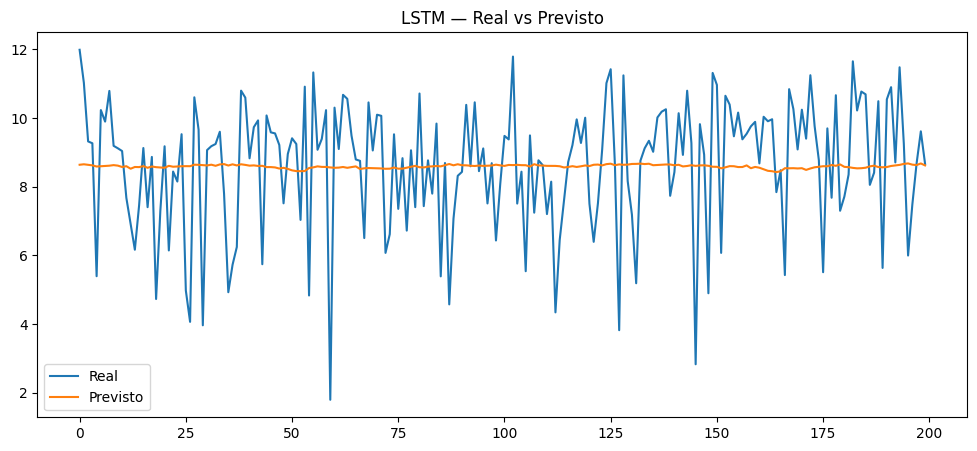

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label="Real")
plt.plot(y_pred[:200], label="Previsto")
plt.legend()
plt.title("LSTM — Real vs Previsto")
plt.savefig(f'{path_img}Real_vs_Previsto.png', dpi=300, bbox_inches='tight')
plt.show()

No gráfico de valores reais versus previstos, observa-se que a LSTM gera uma curva excessivamente suavizada, com baixa capacidade de reagir a picos e variações abruptas nas vendas.

Isso indica que o modelo tende a aprender uma tendência média, falhando em capturar eventos sazonais, promoções e choques pontuais — fatores críticos no comportamento de vendas do Walmart.